In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [4]:
from pathlib import Path

# указывайто тот путь который у вас доступен
#train_dir = Path(your_data_path)
#test_dir = Path(your_data_path)

train_dir = Path(r'C:\Users\serez\Desktop\dataset_monkeys\training')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(r'C:\Users\serez\Desktop\dataset_monkeys\validation')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

print(f"Найдено {len(train_filepaths)} обучающих изображений.")
print(f"Найдено {len(test_filepaths)} тестовых изображений.")

Найдено 1096 обучающих изображений.
Найдено 272 тестовых изображений.


In [5]:
def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# датафрейм с путями к файлам и метками изображений
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Количество изображений: {train_df.shape[0]}\n')
print(f'Количество разных меток: {len(train_df.Label.unique())}\n')
print(f'Метки: {train_df.Label.unique()}')

#смотрим
train_df.head(5)

Number of pictures: 1096

Number of different labels: 10

Labels: ['n3' 'n2' 'n8' 'n0' 'n1' 'n5' 'n7' 'n9' 'n4' 'n6']


,Filepath,Label
0,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n3
1,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n2
2,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n8
3,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n2
4,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n0


In [6]:
# наименования обезьян:
name_dic = {'n0':'alouatta palliata', 
            'n1':'erythrocebus patas', 
            'n2':'cacajao calvus', 
            'n3':'macaca fuscata', 
            'n4':'cebuella pygmea', 
            'n5':'cebus capucinus', 
            'n6':'mico argentatus', 
            'n7':'saimiris ciureus', 
            'n8':'aotus nigriceps', 
            'n9':'trachypithecus johnii'}

# карта лейблво
train_df['Label'] = train_df['Label'].apply(lambda n: name_dic[n])
test_df['Label'] = test_df['Label'].apply(lambda n: name_dic[n])

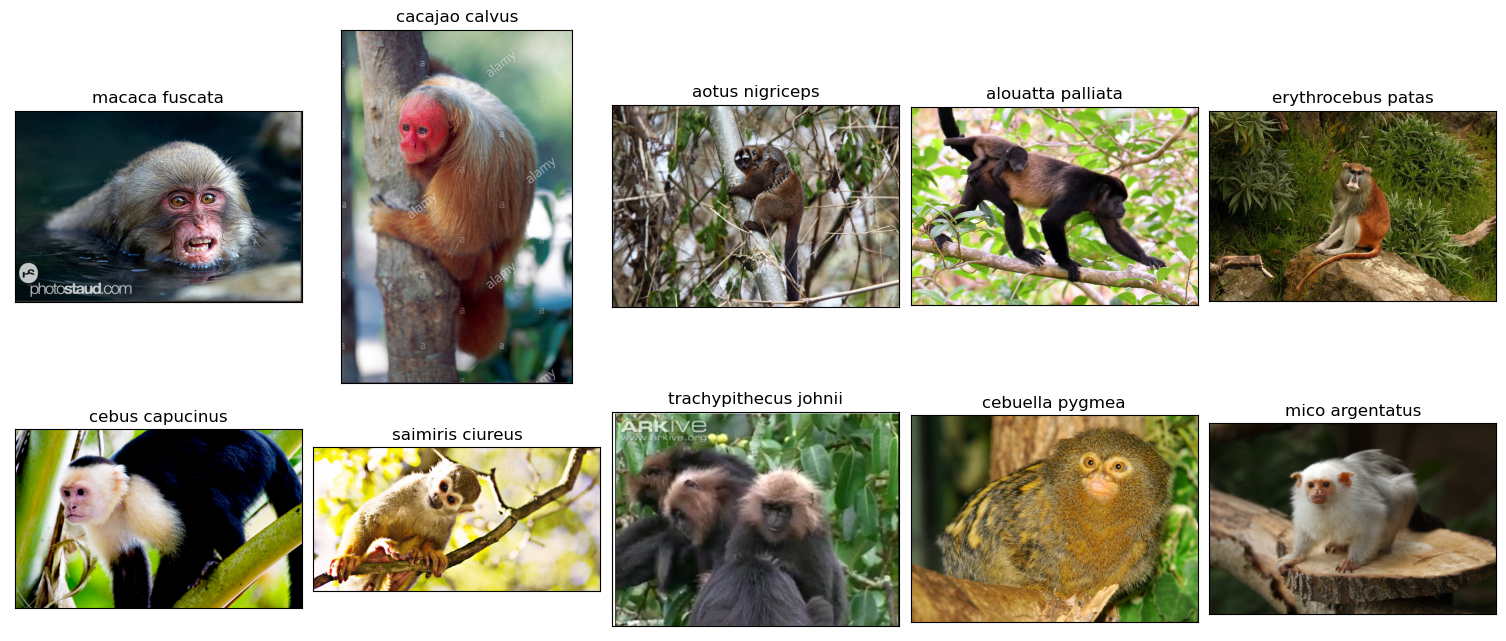

In [7]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 877 validated image filenames belonging to 10 classes.
Found 219 validated image filenames belonging to 10 classes.
Found 272 validated image filenames belonging to 10 classes.


In [11]:
# используем уже пре-трейн модель
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 3s 0us/step


In [12]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
28/28 [==============================] - 49s 2s/step - loss: 0.8350 - accuracy: 0.8027 - val_loss: 0.1543 - val_accuracy: 0.9726
Epoch 2/50
28/28 [==============================] - 40s 1s/step - loss: 0.0530 - accuracy: 0.9875 - val_loss: 0.1080 - val_accuracy: 0.9589
Epoch 3/50
28/28 [==============================] - 40s 1s/step - loss: 0.0273 - accuracy: 0.9932 - val_loss: 0.1144 - val_accuracy: 0.9726
Epoch 4/50
28/28 [==============================] - 38s 1s/step - loss: 0.0088 - accuracy: 0.9989 - val_loss: 0.1065 - val_accuracy: 0.9589
Epoch 5/50
28/28 [==============================] - 39s 1s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0949 - val_accuracy: 0.9817
Epoch 6/50
28/28 [==============================] - 40s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9772
Epoch 7/50
28/28 [==============================] - 38s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9772
Epoch 8/50
28/28 [==

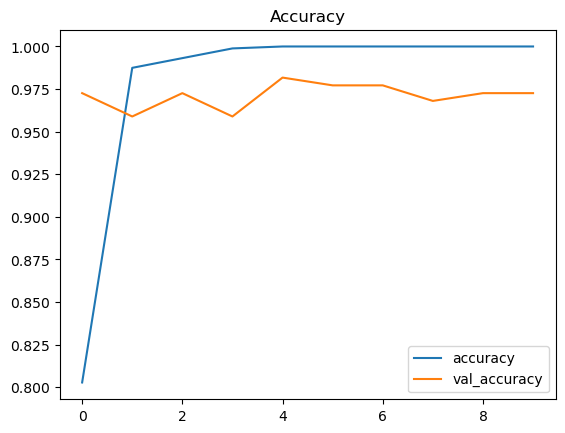

In [13]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

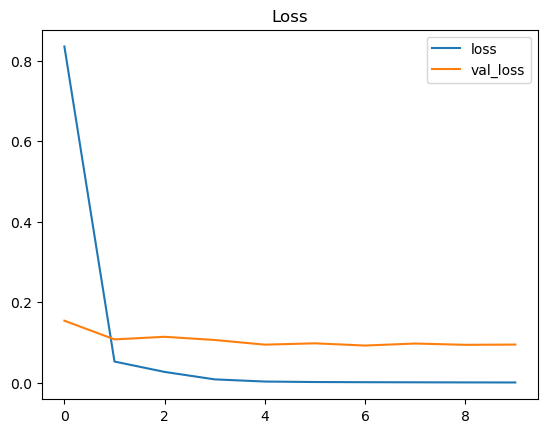

In [14]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [15]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'Первые пять предсказаний: {pred[:5]}')

9/9 [==============================] - 13s 1s/step
The first 5 predictions: ['aotus nigriceps', 'cebus capucinus', 'trachypithecus johnii', 'mico argentatus', 'saimiris ciureus']


In [16]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Точность на тестовом датасете: {acc * 100:.2f}%')

Accuracy on the test set: 98.90%


In [17]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                       precision    recall  f1-score   support

    alouatta palliata       0.96      1.00      0.98        26
      aotus nigriceps       1.00      1.00      1.00        27
       cacajao calvus       1.00      0.96      0.98        27
      cebuella pygmea       0.96      1.00      0.98        26
      cebus capucinus       1.00      1.00      1.00        28
   erythrocebus patas       1.00      1.00      1.00        28
       macaca fuscata       1.00      1.00      1.00        30
      mico argentatus       0.96      1.00      0.98        26
     saimiris ciureus       1.00      1.00      1.00        28
trachypithecus johnii       1.00      0.92      0.96        26

             accuracy                           0.99       272
            macro avg       0.99      0.99      0.99       272
         weighted avg       0.99      0.99      0.99       272



In [19]:
# сохраняем модель в формате HDF5
model.save('model.h5')

INFO:tensorflow:Assets written to: saved_model_directory\assets


INFO:tensorflow:Assets written to: saved_model_directory\assets
